## Generating Explanation using TreeSurrogate (Classification/Regression)

### 1. Classification example using Iris dataset

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

iris = load_iris()

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)
X = df
y = iris.target

In [2]:
# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=5, class_weight="balanced", oob_score=True, random_state=1)
clf.fit(X_train, y_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [4]:
y_hat_train = clf.predict(X_train)
y_hat = clf.predict(X_test)

In [5]:
from sklearn.metrics import classification_report

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_train, y_hat_train, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        31
    class 1       0.97      0.97      0.97        35
    class 2       0.97      0.97      0.97        34

avg / total       0.98      0.98      0.98       100


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       1.00      1.00      1.00        15
    class 2       1.00      1.00      1.00        16

avg / total       1.00      1.00      1.00        50



In [6]:
print(np.unique(y_hat))
print(np.unique(y_test))

[0 1 2]
[0 1 2]


#### Explaination using Pre-pruned TreeSurrogate

In [10]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.dataops import show_in_notebook
from skater.util.logger import _INFO

interpreter = Interpretation(X_train, feature_names=iris.feature_names)
model_inst = InMemoryModel(clf.predict, examples=X_train, model_type='classifier', unique_values=[0, 1],
                           feature_names=iris.feature_names, target_names=iris.target_names, log_level=_INFO)
# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)

In [11]:
# Using the surrogate model learn the decision boundaries learned by the base estimator
# Also report fidelity value when compared to the base estimator
# Learner uses F1 metric as the default metric of choice for classification.
surrogate_explainer.learn(X_train, y_train, use_oracle=True, prune='pre', scorer_type='default')

2018-09-06 00:02:44,720 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-06 00:02:44,829 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (100,)
2018-09-06 00:02:44,831 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.97; oracle score 0.98
2018-09-06 00:02:44,832 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.010000000000000009 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


0.010000000000000009

2018-09-06 00:02:54,448 - skater.util.dataops - INFO - File Name: simple_tree_pre.png


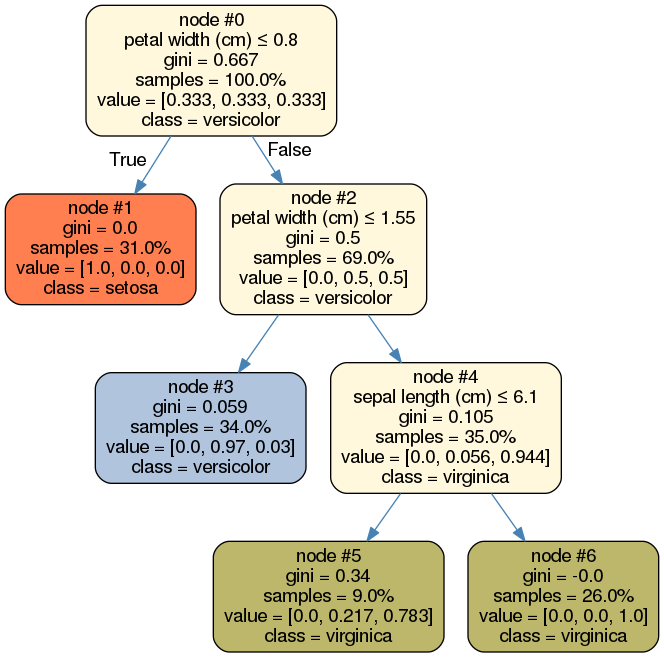

In [12]:
# Only the leaf notes(containing the respective class labels) are colored
surrogate_explainer.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'], 
                                          file_name='simple_tree_pre.png')
show_in_notebook('simple_tree_pre.png', width=400, height=300)

In [13]:
surrogate_explainer.decisions_as_txt()

if petal width (cm) <= 0.800000011920929 {
    Predicted Label: 0
} else {
  if petal width (cm) <= 1.5499999523162842 {
      Predicted Label: 1
  } else {
    if sepal length (cm) <= 6.099999904632568 {
        Predicted Label: 2
    } else {
        Predicted Label: 2
    }
  }
}


In [14]:
# Generating classification metric using the surrogate model(pre-pruning)
# If the performance of a trimmed tree is equivalent to that of a base estimator and interpretability is important
# the surrogate model could possibly be used as the final model as well. 
# However, care must be taken to make sure the results are accurate.
y_hat_pre = surrogate_explainer.predict(X_test)
print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat_pre, target_names=target_names))


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       0.93      0.87      0.90        15
    class 2       0.88      0.94      0.91        16

avg / total       0.94      0.94      0.94        50



#### Evaluating individual prediction

In [15]:
sample_index = 6
X_test.iloc[sample_index]

sepal length (cm)    5.6
sepal width (cm)     2.9
petal length (cm)    3.6
petal width (cm)     1.3
Name: 64, dtype: float64

In [16]:
print("Oracle Model {}:".format(clf.predict(X_test.iloc[sample_index].values.reshape(1, -1))))
print("Using TreeSurrogate {}:".format(surrogate_explainer.predict(X_test.iloc[sample_index].values.reshape(1, -1))))

Oracle Model [1]:
Using TreeSurrogate [1]:


In [17]:
surrogate_explainer.decisions_as_txt('local', X_test.iloc[sample_index])

As petal width (cm)[1.3] > 0.800000011920929 then,
  As petal width (cm)[1.3] <= 1.5499999523162842 then,
      Predicted Label: 1


#### Explaination using TreeSurrogate with post-pruning

In [19]:
surrogate_explainer2 = interpreter.tree_surrogate(oracle=model_inst, seed=5)
# without any pruning
surrogate_explainer2.learn(X_train, y_train, use_oracle=True, prune=None, scorer_type='default')

2018-09-06 00:04:28,806 - skater.core.global_interpretation.tree_surrogate - INFO - No pruning applied ...
2018-09-06 00:04:28,809 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (100,)
2018-09-06 00:04:28,812 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 1.0; oracle score 0.98


-0.020000000000000018

In [20]:
y_hat_post = surrogate_explainer2.predict(X_test)
print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat_post, target_names=target_names))


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       0.94      1.00      0.97        15
    class 2       1.00      0.94      0.97        16

avg / total       0.98      0.98      0.98        50



2018-09-06 00:04:39,921 - skater.util.dataops - INFO - File Name: simple_tree.png


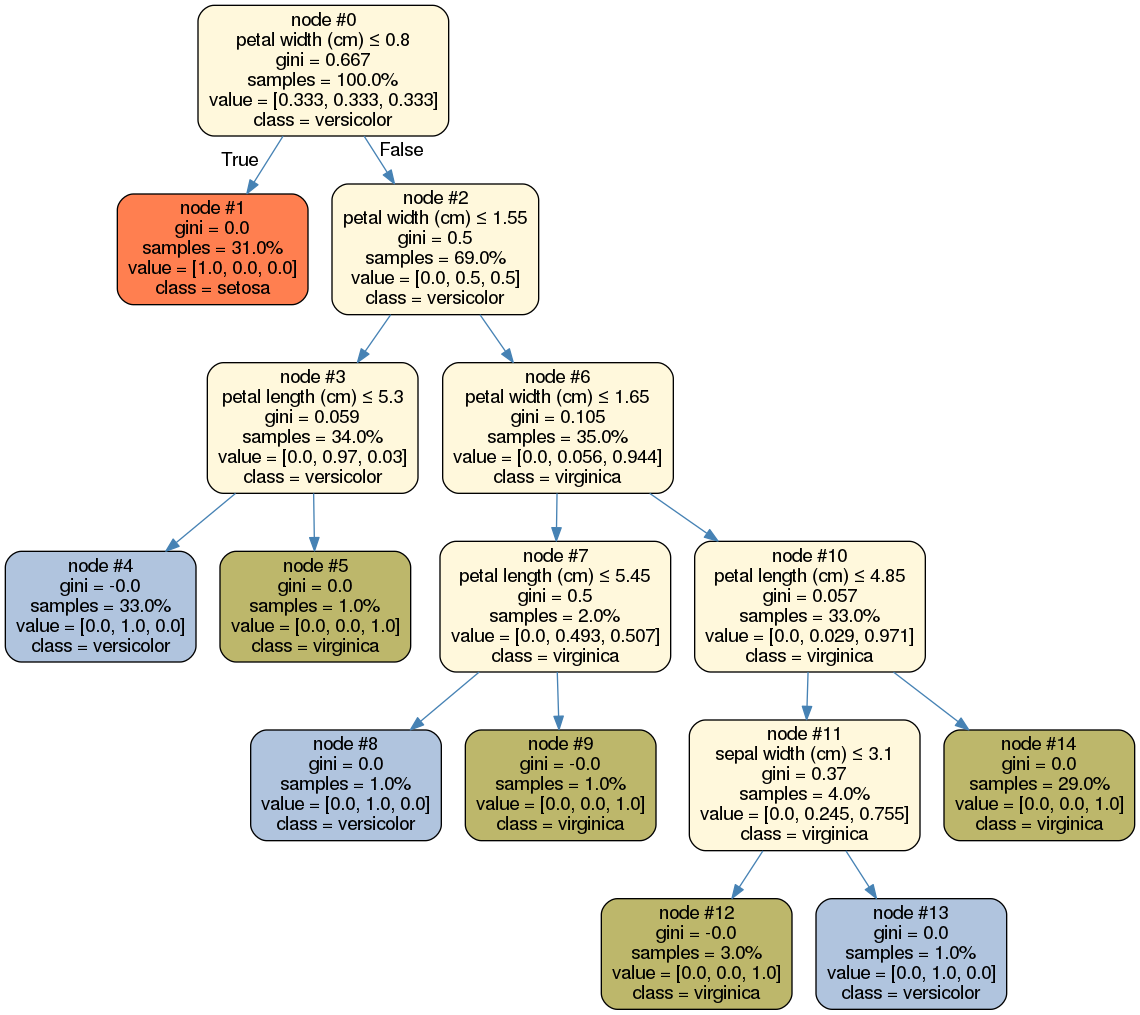

In [21]:
surrogate_explainer2.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'], 
                                           file_name='simple_tree.png')
show_in_notebook('simple_tree.png', width=400, height=300)

In [23]:
surrogate_explainer2.learn(X_train, y_train, use_oracle=True, prune='post', scorer_type='default', verbose=True)

2018-09-06 00:05:04,193 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2018-09-06 00:05:04,196 - skater.core.global_interpretation.tree_surrogate - DEBUG - Unique Labels in ground truth provided [0 1 2]
2018-09-06 00:05:04,197 - skater.core.global_interpretation.tree_surrogate - DEBUG - Unique Labels in predictions generated [0 1 2]
2018-09-06 00:05:04,198 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used <function F1._score at 0x7fbf9106d620>
2018-09-06 00:05:04,200 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 1.0
2018-09-06 00:05:04,202 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.1814814814814815
2018-09-06 00:05:04,203 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 0 back
2018-09-06 00:05:04,205 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.5455769230769231
2018-09-06 00:05:04,20

-0.010000000000000009

2018-09-06 00:05:15,270 - skater.util.dataops - INFO - File Name: simple_tree_post.png


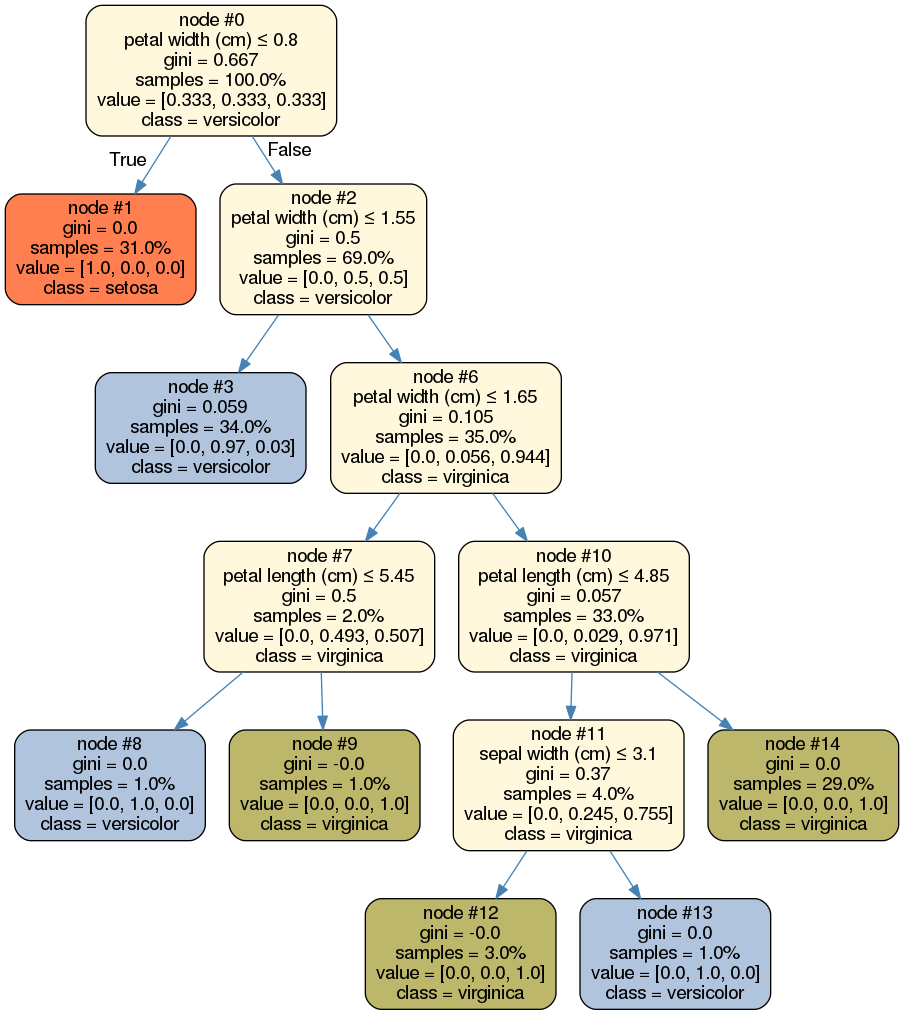

In [24]:
surrogate_explainer2.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'], 
                                           file_name='simple_tree_post.png')
show_in_notebook('simple_tree_post.png', width=400, height=300)

### 2. Regression example

In [25]:
from sklearn.datasets import load_boston
from sklearn.ensemble.forest import RandomForestRegressor
boston = load_boston()

# Create a dataframe with the four feature variables
df = pd.DataFrame(boston.data, columns=boston.feature_names)
X = df
y = boston.target

# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

est = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)
est.fit(X_train, y_train)

y_hat_reg_train = est.predict(X_train)
y_hat_reg = est.predict(X_test)


print("Train Evaluation ...")
from sklearn.metrics import r2_score
print(r2_score(y_train, y_hat_reg_train))

print("Test Evaluation ...")
# Using R^2(Coefficient of Determination for evaluation)
from sklearn.metrics import r2_score
print(r2_score(y_test, y_hat_reg))

Train Evaluation ...
0.9644396137293327
Test Evaluation ...
0.8241067799403498


In [26]:

interpreter = Interpretation(X_train, feature_names=boston.feature_names)
model_inst = InMemoryModel(est.predict, examples=X_train, model_type='regressor', 
                           feature_names=boston.feature_names, log_level=_INFO)
# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer_reg = interpreter.tree_surrogate(oracle=model_inst, seed=5)

# surrogate_explainer_reg = interpreter_reg.tree_surrogate(estimator_type='regressor',
#                                                          feature_names=boston.feature_names, seed=5)

In [29]:
# The score returned is the fidelity score = difference in performance between the values returned by the Oracle and
# the surrogate model. If the difference is big then the surrogate model most likely is not a good representation
# of the base model.
surrogate_explainer_reg.learn(X_train, y_train, use_oracle=True, scorer_type='r2', prune='post', verbose=False)

2018-09-06 00:07:01,649 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2018-09-06 00:07:01,658 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used <function RSquared._score at 0x7fbf9106d400>
2018-09-06 00:07:01,659 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 1.0
2018-09-06 00:07:01,766 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [3, 4, 9, 10, 11, 14, 15, 16, 17, 18, 21, 24, 25, 26, 30, 33, 35, 36, 39, 42, 44, 46, 47, 50, 51, 55, 56, 57, 58, 61, 64, 65, 68, 70, 73, 75, 76, 77, 78, 80, 84, 85, 89, 90, 93, 99, 100, 102, 103, 105, 108, 114, 115, 118, 119, 121, 122, 125, 128, 130, 134, 135, 136, 137, 141, 142, 149, 151, 152, 155, 161, 172, 175, 182, 221, 233, 243, 246, 256, 270, 283, 289, 308, 326, 332, 334, 341, 346, 351, 378, 382, 456, 471, 537]
2018-09-06 00:07:01,767 - skater.core.global_interpretation.tree_surro

-0.026000000000000023

In [30]:
y_hat_reg_train_s = surrogate_explainer_reg.predict(X_train)
y_hat_reg_s = surrogate_explainer_reg.predict(X_test)


print("Train Evaluation ...")
from sklearn.metrics import r2_score
print(r2_score(y_train, y_hat_reg_train_s))

print("Test Evaluation ...")
# Using R^2(Coefficient of Determination for evaluation)
from sklearn.metrics import r2_score
print(r2_score(y_test, y_hat_reg_s))

Train Evaluation ...
0.9521791261489421
Test Evaluation ...
0.8119833510981067


2018-09-06 00:07:31,817 - skater.util.dataops - INFO - File Name: simple_tree_reg.png


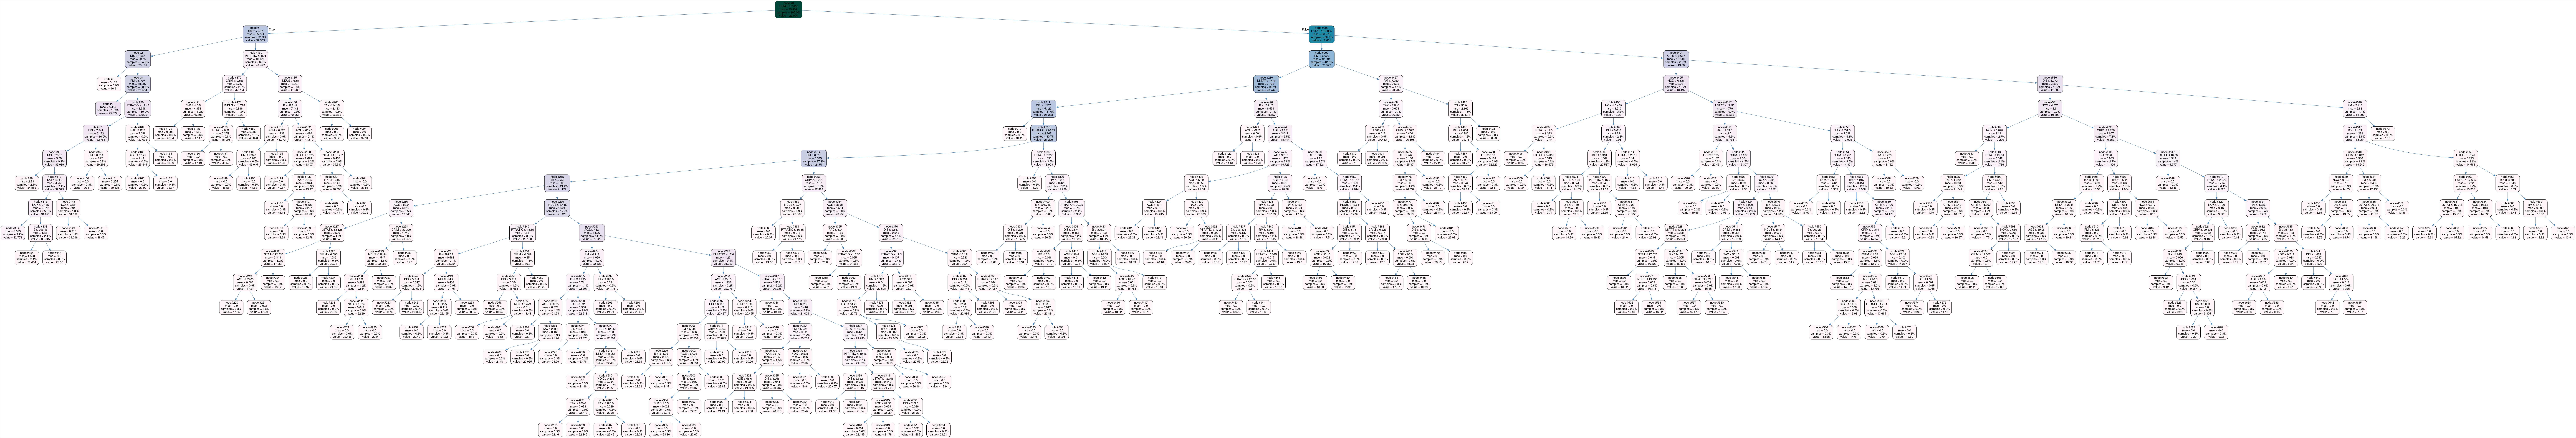

In [31]:
%matplotlib inline
surrogate_explainer_reg.plot_global_decisions(file_name='simple_tree_reg.png')
show_in_notebook('simple_tree_reg.png', width=1400, height=700)

In [34]:
# Disable this line to get an interactive plot to zoom in and out
# show_in_notebook('simple_tree_reg.png', width=1000, height=800, mode='interactive')

#### Evaluating individual prediction

In [35]:
sample_index = 6
X_test.iloc[sample_index]

CRIM         0.31827
ZN           0.00000
INDUS        9.90000
CHAS         0.00000
NOX          0.54400
RM           5.91400
AGE         83.20000
DIS          3.99860
RAD          4.00000
TAX        304.00000
PTRATIO     18.40000
B          390.70000
LSTAT       18.33000
Name: 316, dtype: float64

In [36]:
print("Oracle Model {}:".format(est.predict(X_test.iloc[sample_index].values.reshape(1, -1))))
print("Using TreeSurrogate {}:".format(surrogate_explainer_reg.predict(X_test.iloc[sample_index].values.reshape(1, -1))))

Oracle Model [20.03]:
Using TreeSurrogate [20.83]:


In [37]:
surrogate_explainer_reg.decisions_as_txt('local', X_test.iloc[sample_index])

As LSTAT[18.33] > 7.864999771118164 then,
  As LSTAT[18.33] > 16.084999084472656 then,
    As CRIM[0.31827] <= 5.656595230102539 then,
      As NOX[0.544] > 0.531000018119812 then,
        As LSTAT[18.33] <= 19.549999237060547 then,
          As AGE[83.2] <= 83.5999984741211 then,
            As B[390.7] > 385.83502197265625 then,
                Value: [[20.83]]
